# STM Dataset Simulation and Refactor

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import random
import math

## Datasets
### hour.csv

This csv file contains the information of the number of trips that ended in a specific time hour.

- season:
    - 1: Winter,
    - 2: Spring,
    - 3: Summer
    - 4: Fall
- year:
    - 0: 2011,
    - 1: 2012
- month: 1 - January to 12 - December
- hr: 0 to 23
- holiday:
    - 1: holiday
    - 0: normal work/week day
- weekday: 1 - Monday to 7 - Sunday
- workingday:
    - 0: weekend and holiday
    - 1: work day
- weathersit:
    - 1: Clear, Few Clowds, Partly Cloudy, 
    - 2: Mist and Cloudy, Mist and Broken clouds, Mist and Few clouds, Mist, 
    - 3: Light Snow, Light Rain and Thunderstorm and Scattered clouds, Light Rain and Scattered clouds, 
    - 4: Heavy Rain and Ice Pallets and Thunderstorm and Mist, Snow and Fog
- cnt: number of ended trips

It also contians a simple weather report for that hour, with:
- temperature
- temperature feeling
- humidity
- windspeed

### stations.csv

This csv file contains the information of the stations we will use to simulate the trips.

In [3]:
data = pd.read_csv("./hour.csv")
data = data.dropna().drop(columns=["instant", "registered", "casual"])
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [5]:
stations = pd.read_csv("./stationshour.csv").sort_values(by=["Station ID"])[:40]
stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


In [31]:
stations_ids = [x[0] for x in stations.values]

avg_point = (stations.values[0][2], stations.values[0][3])
for point in stations.values[1:]:
    avg_point = ((avg_point[0] + point[2]), (point[3] + avg_point[1]))

avg_point = (avg_point[0] / len(stations.values), avg_point[1] / len(stations.values))

# the closer to the center, the more probability of having a trip
distances = {x[0]: round(math.sqrt(math.pow(avg_point[0]-x[2],2) + math.pow(avg_point[1]-x[3],2))*1000) for x in stations.values}

In [35]:
def random_date(start):
    ind = random.randint(1,59)
    return datetime(start.year, start.month, start.day, start.hour, ind, start.second)

def calculate_distance(start, end):
    x = math.sin(start[2]) * math.sin(end[2]) + math.cos(start[2]) * math.cos(end[2]) * math.cos(end[3] - start[3])
    return math.acos(x) * 6371  # returns meters

trips = []

for hour in data.values:
    for trip in range(hour[-1]):
        station_start = random.choice(stations.values)
        station_end = random.choices(stations.values, weights=distances.values(), k=1)[0]
        distance = calculate_distance(station_start, station_end)
        time_travelling = (distance * random.randint(10,100)) / (20000 / 60)    # distance * randint to simulate a normal travel
        hour_date = hour[0].replace("-", "/")
        end_date_trip = random_date(datetime.strptime(f"{hour_date} {hour[4]:02d}:00:00", "%Y/%m/%d %H:%M:%S"))
        start_date_trip = end_date_trip - timedelta(minutes=int(time_travelling))
        trips.append({
            # "ID": count, 
            "StartStationID": station_start[0], 
            "EndStationID": station_end[0], 
            # "Duration": int(time_travelling), 
            "StartDate": start_date_trip, 
            "EndDate": end_date_trip,


            # the rest of the information place here

            
            })

trips = pd.DataFrame(trips)
trips.head()

,ID,StartStationID,EndStationID,Duration,StartDate,EndDate
0,1,11,42,13,2011-01-01 00:45:00,2011-01-01 00:58:00
1,2,29,37,9,2011-01-01 00:31:00,2011-01-01 00:40:00
2,3,3,36,35,2010-12-31 23:50:00,2011-01-01 00:25:00
3,4,30,31,4,2011-01-01 00:34:00,2011-01-01 00:38:00
4,5,32,13,21,2010-12-31 23:54:00,2011-01-01 00:15:00


In [10]:
data.to_csv("../CSVFiles/data.csv")
stations.to_csv("../CSVFiles/stations.csv")
# for github upload
trips[:int(len(trips.values)/3)].to_csv("../CSVFiles/trips1.csv")
trips[int(len(trips.values)/3):int(len(trips.values)*2/3)].to_csv("../CSVFiles/trips2.csv")
trips[int(len(trips.values)*2/3):].to_csv("../CSVFiles/trips3.csv")

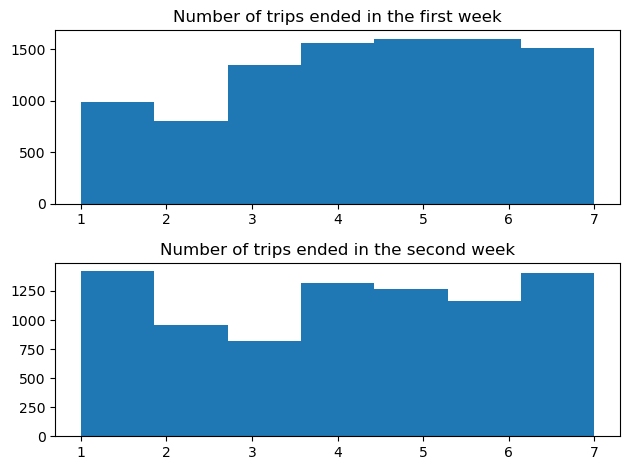

In [56]:
week = {x:0 for x in range(1,8)}
week_2 = {x:0 for x in range(1,8)}

first_day = data.values[0][0]
one_week = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=7)
two_week = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=14)

for trip in trips.values:
    if trip[-1] <= one_week:
        week[trip[-1].day] += 1
    elif trip[-1] > one_week and trip[-1] <= two_week:
        week_2[trip[-1].day%7+1] += 1
    else:
        break
    

fig, axs = plt.subplots(2)

axs[0].hist(week.keys(), len(week), weights=list(week.values()))
axs[0].set_title("Number of trips ended in the first week")

axs[1].hist(week_2.keys(), len(week_2), weights=list(week_2.values()))
axs[1].set_title(f"Number of trips ended in the second week")

fig.tight_layout()


Text(0.5, 1.0, 'Number of trips ended in a year by weeks')

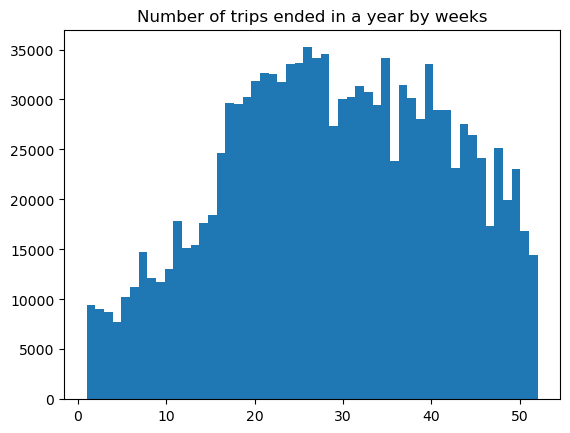

In [53]:
year = {x:0 for x in range(1,53)}

one_year = datetime.strptime(first_day, "%Y-%m-%d") + timedelta(days=365)

for trip in trips.values:
    if trip[-1] > one_year:
        break

    year[trip[-1].week] += 1
    

plt.hist(year.keys(), len(year), weights=list(year.values()))
plt.title("Number of trips ended in a year by weeks")


{1: 179, 2: 585, 3: 344, 4: 114, 5: 330, 6: 142, 7: 358, 8: 376, 9: 293, 10: 310, 11: 40, 12: 31, 13: 82, 14: 104, 15: 21, 16: 59, 17: 143, 18: 42, 19: 62, 20: 98, 21: 123, 22: 108, 23: 74, 24: 12, 25: 93, 26: 92, 27: 164, 28: 140, 29: 547, 30: 303, 31: 345, 32: 334, 33: 458, 34: 118, 36: 480, 37: 584, 38: 633, 39: 404, 40: 395, 42: 293}


Text(0.5, 1.0, 'Number of trips ended by station during the first week')

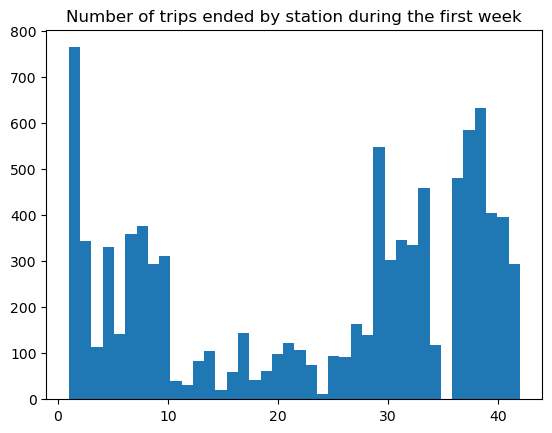

In [43]:
# num of trips by station

trips_station = {x[0]:0 for x in stations.values}

for trip in trips.values:
    if trip[-1] > one_week:
        break

    trips_station[trip[1]] += 1

plt.hist(trips_station.keys(), len(trips_station), weights=list(trips_station.values()))
plt.title("Number of trips ended by station during the first week")

Text(0.5, 1.0, 'Number of trips ended by station during the first year')

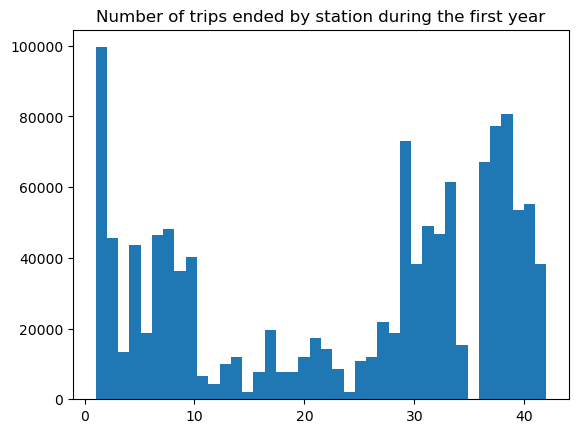

In [57]:
# num of trips by station by year

year_stations = {x[0]:0 for x in stations.values}

for trip in trips.values:
    if trip[-1] > one_year:
        break

    year_stations[trip[1]] += 1

plt.hist(year_stations.keys(), len(year_stations), weights=list(year_stations.values()))
plt.title("Number of trips ended by station during the first year")